<a href="https://colab.research.google.com/github/milind9321/Mtech-mini-project/blob/main/XG_BOOST_CropYield_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==================== Imports ====================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from matplotlib.colors import LinearSegmentedColormap

warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# ==================== Load Dataset ====================
file_path = 'data_season.csv'
df = pd.read_csv(file_path)
df.head()

,Year,Location,Area,Rainfall,Temperature,Soil type,Irrigation,yeilds,Humidity,Crops,price,Season
0,2004,Mangalore,1279,2903.1,27.0,Alluvial,Drip,2570.0,57.0,Coconut,200000,Kharif
1,2004,Mangalore,13283,2903.1,27.0,Alluvial,Drip,27170.0,57.5,Coconut,4847,Kharif
2,2004,Mangalore,52119,2903.1,27.0,Alluvial,Drip,114744.0,57.0,Coconut,51239,Kharif
3,2004,Mangalore,725,2996.6,27.0,Alluvial,Drip,1402.0,55.0,Coconut,216396,Kharif
4,2004,Mangalore,12885,2996.6,27.0,Alluvial,Drip,23456.0,56.0,Coconut,2644,Kharif


In [ ]:
# ==================== Data Preprocessing ====================
df.rename(columns={'yeilds': 'yield'}, inplace=True)
df['Soil type'].fillna('Unknown', inplace=True)

In [ ]:
# ==================== Check for Missing Values ====================
print("\nMissing values after cleaning:")
print(df.isnull().sum())


Missing values after cleaning:
Year           0
Location       0
Area           0
Rainfall       0
Temperature    0
Soil type      0
Irrigation     0
yield          0
Humidity       0
Crops          0
price          0
Season         0
dtype: int64


In [ ]:
# ==================== Exploratory Data Analysis ====================
print("\nDescriptive Statistics:")
print(df.describe())


Descriptive Statistics:
              Year          Area     Rainfall  Temperature          yield  \
count  3158.000000   3158.000000  3158.000000  3158.000000    3158.000000   
mean   2009.929702   9329.913553  2813.126662    65.893699   23258.976916   
std       5.100895  15180.465396  1163.829953    60.814037   58228.985033   
min    2004.000000      1.000000   233.000000    26.800000       2.000000   
25%    2004.000000    153.000000  2903.100000    27.000000     393.000000   
50%    2010.000000   2127.000000  3296.000000    38.000000    2783.000000   
75%    2015.000000  10910.000000  3550.000000    43.000000    6589.000000   
max    2019.000000  52119.000000  3729.800000   222.000000  623687.000000   

          Humidity          price  
count  3158.000000    3158.000000  
mean     55.582331   86271.279291  
std       2.469773   94123.160706  
min      50.000000     637.000000  
25%      54.000000    2644.000000  
50%      56.000000   45186.000000  
75%      57.000000  203317.00

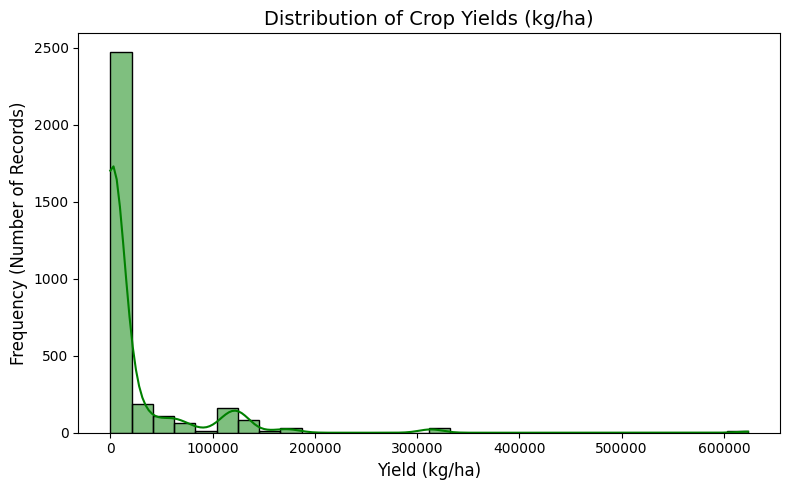

In [ ]:
# Yield distribution plot
plt.figure(figsize=(8, 5))
sns.histplot(df['yield'], kde=True, color='green', bins=30)
plt.title('Distribution of Crop Yields (kg/ha)', fontsize=14)
plt.xlabel('Yield (kg/ha)', fontsize=12)
plt.ylabel('Frequency (Number of Records)', fontsize=12)
plt.tight_layout()
plt.show()

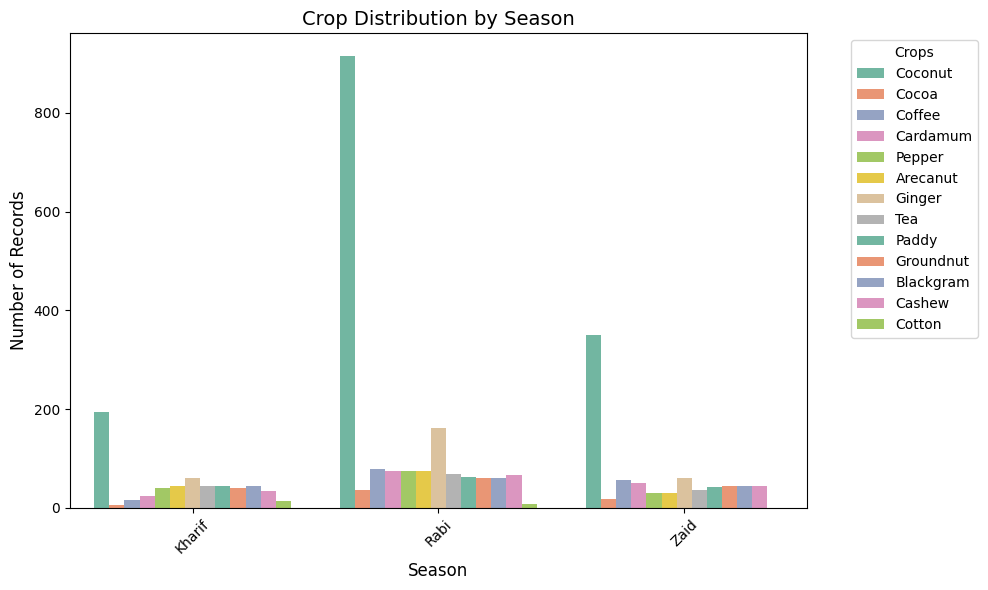

In [ ]:
# Crop distribution by season
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Season', hue='Crops', palette='Set2')
plt.title('Crop Distribution by Season', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Crops', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

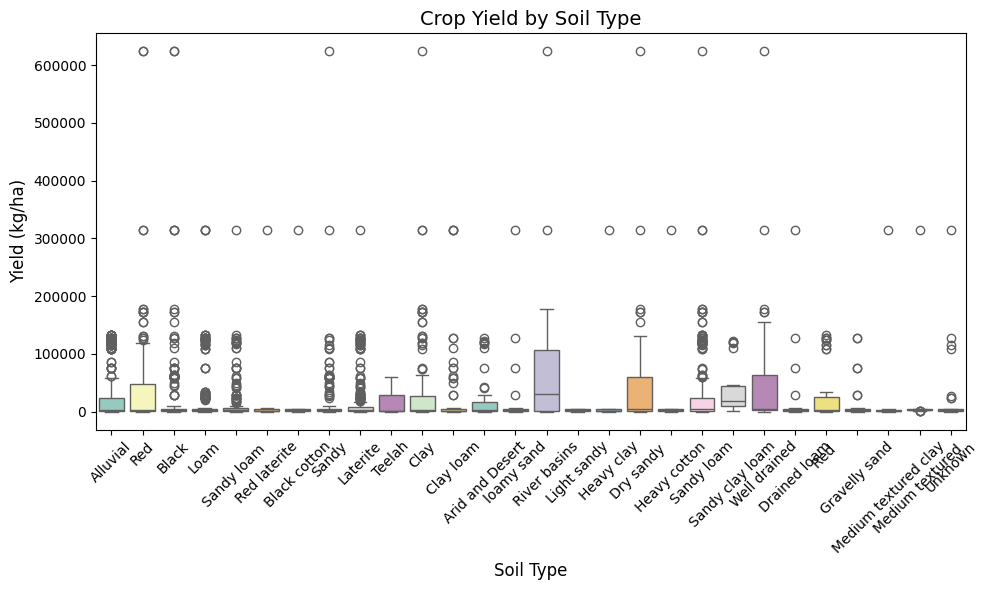

In [ ]:
# Boxplot of yield by soil type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Soil type', y='yield', palette='Set3')
plt.title('Crop Yield by Soil Type', fontsize=14)
plt.xlabel('Soil Type', fontsize=12)
plt.ylabel('Yield (kg/ha)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

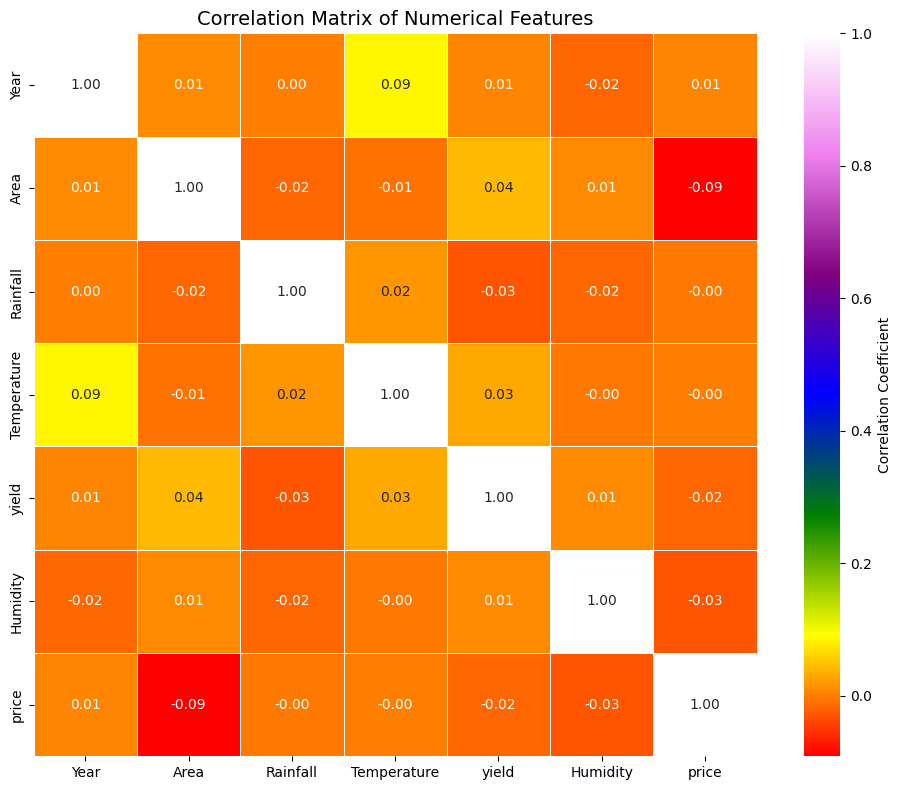

In [ ]:
# ==================== Correlation Matrix with Custom Colors ====================
colors = ['red', 'yellow', 'green', 'blue', 'purple', 'violet', 'white']
custom_cmap = LinearSegmentedColormap.from_list("custom_colormap", colors, N=256)

plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap=custom_cmap,
    fmt='.2f',
    linewidths=0.5,
    square=True,
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title('Correlation Matrix of Numerical Features', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# ==================== Feature Selection ====================
X = df.drop(columns=['yield', 'Crops', 'Location', 'Soil type', 'Irrigation', 'Season'])
y = df['yield']

In [ ]:
# ==================== Train/Test Split ====================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# ==================== Model Initialization ====================
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 100,
    'random_state': 42
}

xgb_model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'eval')], early_stopping_rounds=10, verbose_eval=True)

[0]	eval-rmse:58015.06632
[1]	eval-rmse:58088.37349
[2]	eval-rmse:58187.95245
[3]	eval-rmse:58299.72104
[4]	eval-rmse:58419.52249
[5]	eval-rmse:58433.89226
[6]	eval-rmse:58592.56738
[7]	eval-rmse:58723.20710
[8]	eval-rmse:58771.04233
[9]	eval-rmse:58857.20702


In [ ]:
# ==================== Prediction & Evaluation ====================
predictions = xgb_model.predict(dtest)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)

print("\n📊 Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f} kg²/ha²")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} kg/ha")
print(f"Mean Absolute Error (MAE): {mae:.2f} kg/ha")
print(f"R-squared (R²) Score: {r2:.4f}")


📊 Model Evaluation:
Mean Squared Error (MSE): 3476165434.91 kg²/ha²
Root Mean Squared Error (RMSE): 58959.01 kg/ha
Mean Absolute Error (MAE): 32715.07 kg/ha
R-squared (R²) Score: -0.0335


In [ ]:
# ==================== Prediction Function ====================
def predict_yield(new_data):
    new_data_df = pd.DataFrame([new_data])
    missing_cols = set(X.columns) - set(new_data_df.columns)
    for col in missing_cols:
        new_data_df[col] = 0
    new_data_df = new_data_df[X.columns]

    new_data_dmatrix = xgb.DMatrix(new_data_df)
    predicted_yield = xgb_model.predict(new_data_dmatrix)
    print(f"\n🌾 Predicted Crop Yield: {predicted_yield[0]:.2f} kg/ha")
    return predicted_yield[0]

In [ ]:
# ==================== Test Prediction ====================
dummy_input = {
    'Temperature': 29,    # Celsius
    'Rainfall': 233,      # mm
    'Humidity': 57,       # %
    'Area': 725,          # hectares
    'Year': 2015,
    'price': 4000         # ₹ per quintal
}

print("\n🧪 Testing with Dummy Input:")
for key, val in dummy_input.items():
    print(f"{key}: {val}")

predict_yield(dummy_input)



🧪 Testing with Dummy Input:
Temperature: 29
Rainfall: 233
Humidity: 57
Area: 725
Year: 2015
price: 4000

🌾 Predicted Crop Yield: 18140.93 kg/ha


np.float32(18140.93)